In [108]:
# 경고(warning) 비표시
import warnings
warnings.filterwarnings('ignore')

# 고객 행동 예측

### 1 : 데이터 읽고 확인

In [109]:
import pandas as pd

In [110]:
customer_join = pd.read_csv('./data/customer_join.csv')

customer_join.head()

# customer_join.isnull().sum()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period
0,OA832399,XXXX,C01,F,2015-05-01,NaN,CA1,0,0_종일,10500,2_일반,4.833333,5.0,8,2,1,2019-04-30,47
1,PL270116,XXXXX,C01,M,2015-05-01,NaN,CA1,0,0_종일,10500,2_일반,5.083333,5.0,7,3,1,2019-04-30,47
2,OA974876,XXXXX,C01,M,2015-05-01,NaN,CA1,0,0_종일,10500,2_일반,4.583333,5.0,6,3,1,2019-04-30,47
3,HD024127,XXXXX,C01,F,2015-05-01,NaN,CA1,0,0_종일,10500,2_일반,4.833333,4.5,7,2,1,2019-04-30,47
4,HD661448,XXXXX,C03,F,2015-05-01,NaN,CA1,0,2_야간,6000,2_일반,3.916667,4.0,6,1,1,2019-04-30,47


In [111]:
use_log_months = pd.read_csv('./data/use_log_months.csv')

use_log_months.head()

use_log_months.isnull().sum()

연월             0
customer_id    0
count          0
dtype: int64

In [112]:
use_log = pd.read_csv('./data/use_log.csv')

use_log.head()

use_log.isnull().sum()

log_id         0
customer_id    0
usedate        0
dtype: int64

### 2 : 클러스터링으로 회원 그룹화

In [113]:
# mean, median, max, min : 월 이용 횟수, 1~8
# membership_period : 기간, 최댓값 (47)
# 표준화 : StandardScaler()
# 필드 추출 , K-means 알고리즘 사용 (클러스터 개수: 4개)

In [114]:
customer_clustering = customer_join[['mean','median','max','min','membership_period']]
customer_clustering.head()

,mean,median,max,min,membership_period
0,4.833333,5.0,8,2,47
1,5.083333,5.0,7,3,47
2,4.583333,5.0,6,3,47
3,4.833333,4.5,7,2,47
4,3.916667,4.0,6,1,47


In [115]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# 표준화
sc = StandardScaler()
customer_clustering_sc = sc.fit_transform(customer_clustering)

# k-means 
kmeans = KMeans(n_clusters=4,random_state=0)
clusters = kmeans.fit(customer_clustering_sc)

# 클러스터링 결과
customer_clustering['cluster'] = clusters.labels_
print(customer_clustering['cluster'].unique)
customer_clustering.head()



<bound method Series.unique of 0       3
1       3
2       3
3       3
4       3
       ..
4187    1
4188    1
4189    1
4190    1
4191    1
Name: cluster, Length: 4192, dtype: int32>


,mean,median,max,min,membership_period,cluster
0,4.833333,5.0,8,2,47,3
1,5.083333,5.0,7,3,47,3
2,4.583333,5.0,6,3,47,3
3,4.833333,4.5,7,2,47,3
4,3.916667,4.0,6,1,47,3


In [116]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np

# Assuming customer_clustering is your original data
sc = StandardScaler()
customer_clustering_sc = sc.fit_transform(customer_clustering)

# k-means
kmeans = KMeans(n_clusters=4, random_state=np.random.RandomState(seed=1))
clusters = kmeans.fit_predict(customer_clustering_sc)

# Assign the cluster labels to the DataFrame
customer_clustering['cluster'] = clusters

# Print unique cluster labels
print(customer_clustering['cluster'].unique())

# Display the first few rows of the DataFrame
print(customer_clustering.head())


[2 0 3 1]
       mean  median  max  min  membership_period  cluster
0  4.833333     5.0    8    2                 47        2
1  5.083333     5.0    7    3                 47        2
2  4.583333     5.0    6    3                 47        2
3  4.833333     4.5    7    2                 47        2
4  3.916667     4.0    6    1                 47        2


In [117]:
# 주성분 분석
from sklearn.decomposition import PCA # 데이터의 차원을 줄이는데 사용

X = customer_clustering_sc
pca = PCA(n_components=2)
pca.fit(X)
x_pca = pca.transform(X)

# 2차원으로 축소한 데이터, 클러스터링 결과 저장
pca_df =pd.DataFrame(x_pca)
pca_df['cluster'] = customer_clustering['cluster']
pca_df

,0,1,cluster
0,-1.255552,2.044917,2
1,-1.157708,2.076601,2
2,-1.495310,1.951167,2
3,-1.580267,1.912520,2
4,-2.387420,1.603435,2
...,...,...,...
4187,3.011843,-0.111824,1
4188,4.929331,0.657259,1
4189,3.011843,-0.111824,1
4190,5.888075,1.041801,1


### 3 : 클러스터링 결과 분석

In [118]:
customer_clustering.columns = ['월평균값','월중앙값','월최댓값','월최솟값','회원기간','cluster']
customer_clustering.groupby('cluster').count()




,월평균값,월중앙값,월최댓값,월최솟값,회원기간
cluster,,,,,
0,763,763,763,763,763
1,846,846,846,846,846
2,1249,1249,1249,1249,1249
3,1334,1334,1334,1334,1334


In [119]:
# 그룹별 평균값 출력
customer_clustering.groupby('cluster').mean()
# 그룹3은 회원기간은 짧지만 이용률이 높은 회원임

,월평균값,월중앙값,월최댓값,월최솟값,회원기간
cluster,,,,,
0,3.054713,2.888598,4.756225,1.653997,9.263434
1,8.054608,8.039598,10.009456,6.160757,7.072104
2,4.677494,4.671337,7.232986,2.153723,36.915933
3,5.524239,5.375187,8.745877,2.687406,14.843328


### 4 : 클러스터링 결과 가시화

In [120]:
# 주성분 분석
from sklearn.decomposition import PCA # 데이터의 차원을 줄이는데 사용

X = customer_clustering_sc
pca = PCA(n_components=2)
pca.fit(X)
x_pca = pca.transform(X)

# 2차원으로 축소한 데이터, 클러스터링 결과 저장
pca_df =pd.DataFrame(x_pca)
pca_df['cluster'] = customer_clustering['cluster']
pca_df

,0,1,cluster
0,-1.255552,2.044917,2
1,-1.157708,2.076601,2
2,-1.495310,1.951167,2
3,-1.580267,1.912520,2
4,-2.387420,1.603435,2
...,...,...,...
4187,3.011843,-0.111824,1
4188,4.929331,0.657259,1
4189,3.011843,-0.111824,1
4190,5.888075,1.041801,1


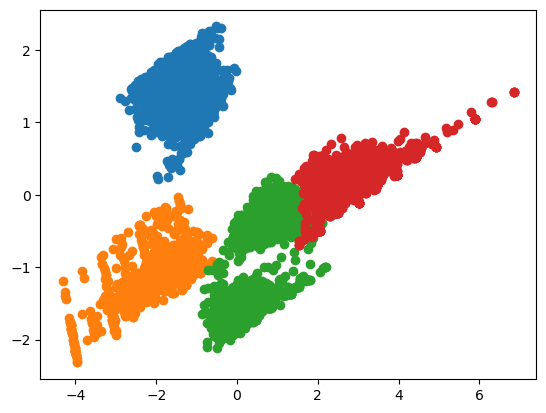

In [121]:
import matplotlib.pyplot as plt

for i in customer_clustering['cluster'].unique():
    tmp = pca_df.loc[pca_df['cluster']==i]
    plt.scatter(tmp[0],tmp[1])

### 5 : 클러스터링 결과를 바탕으로 탈퇴회원 경향 파악

In [122]:
# 4개의 그룹에서 지속 회원과 탈퇴 회원이 얼마나 있을까?
# 지속회원과 탈퇴 회원을 집계 : is_deleted

# customer_clustering, customer 결합
customer_clustering = pd.concat([customer_clustering, customer_join], axis=1)
# 탈퇴 회원 특정
customer_clustering.groupby(["cluster", "is_deleted"], as_index=False).count()[["cluster", "is_deleted", "customer_id"]]



# 클러스터 2는 지속회원이 많음
# 클러스터 1은 탈퇴회원만 있음
# 클러스터 3은 골고루 분포되어있음

,cluster,is_deleted,customer_id
0,0,1,763
1,1,0,827
2,1,1,19
3,2,0,1230
4,2,1,19
5,3,0,785
6,3,1,549


### 6 : 다음달의 이용횟수 예측을 위해 테이터 준비

In [123]:
# routine_flag

customer_clustering.groupby(["cluster", "routine_flg"], as_index=False).count()[["cluster", "routine_flg", "customer_id"]]



,cluster,routine_flg,customer_id
0,0,0,497
1,0,1,266
2,1,0,52
3,1,1,794
4,2,0,2
5,2,1,1247
6,3,0,228
7,3,1,1106


### 7 : 특징이 되는 변수 추가

### 8 : 다음달 이용횟수를 예측하는 모델 구축

### 9 : 모델에 기여하는 변수 확인

### 10: 다음달의 이용횟수 예측